In [429]:
import zipfile
import os

zip_file_path = './images.zip'

extract_dir = '/images'

os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Successfully extracted contents to {extract_dir}.")

OSError: [Errno 30] Read-only file system: '/images'

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
import torch.optim as optim
import torchvision.utils as vutils
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

In [3]:
transform=transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))])

In [4]:

class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, fname) for fname in os.listdir(root_dir) if fname.endswith(('png', 'jpg', 'jpeg'))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

In [5]:
images_folder_path = "/Users/priyadarshni/Learning Deep learning/Clothes creation/images"
trainData = CustomImageDataset(root_dir=images_folder_path, transform=transform)

In [6]:
len(trainData)

13752

In [7]:
batch_size=32

In [8]:
trainLoader=torch.utils.data.DataLoader(trainData,batch_size=batch_size,shuffle=True,drop_last=True)

In [9]:
trainLoader.batch_size

32

In [10]:
class PrintLayer(nn.Module):
    def forward(self, x):
        print(x.shape)
        return x
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.descriminator=nn.Sequential(
            nn.Conv2d(3,64,4,4,1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(64,128,4,2,1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(128,256,4,2,1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(256,1,4,1,0),
            nn.Flatten(),
            nn.Sigmoid(),
        )
    def forward(self,input):
        output=self.descriminator(input)
        return output
    

In [11]:
sampleInput=torch.rand(32,3,64,64)
print(sampleInput.shape)

torch.Size([32, 3, 64, 64])


In [12]:
discriminatorModel=Discriminator()

In [13]:
sampleOutput=discriminatorModel(sampleInput)

In [14]:
class Generator(nn.Module):
    def __init__(self, latent_size):
        super(Generator, self).__init__()
        self.generator = nn.Sequential(
            nn.ConvTranspose2d(latent_size, 128, kernel_size=4, stride=2, padding=0),
            nn.ReLU(),
            
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=4, padding=0),
            nn.ReLU(),
            
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=4, padding=0),
            nn.ReLU(),

            nn.Tanh()
        )
    
    def forward(self, noise):
        output = self.generator(noise)
        return output


In [15]:
latent_size = 100
generatorModel = Generator(latent_size)

noise = torch.randn(batch_size, latent_size, 1, 1)
print("Noise shape:", noise.shape)

fake_images = generatorModel(noise)
print(fake_images.shape)

Noise shape: torch.Size([32, 100, 1, 1])
torch.Size([32, 3, 64, 64])


In [16]:
learning_rate=0.001
weight_decay=1e-2


In [17]:
generatorOptimizer=torch.optim.Adam(generatorModel.parameters(),lr=learning_rate,weight_decay=weight_decay)
discriminatorOptimizer=torch.optim.Adam(discriminatorModel.parameters(),lr=learning_rate,weight_decay=weight_decay)

In [18]:
criterion = nn.BCELoss()

In [19]:
trainLoader.batch_size

32

In [20]:
print(f"Total images in dataset: {len(trainData)}")


Total images in dataset: 13752


In [21]:
for images in trainLoader:
    print(f"Batch size: {images.shape}")
    break  # Check only the first batch

Batch size: torch.Size([32, 3, 64, 64])


In [22]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [23]:
def save_samples(index, show=True):
    noise=torch.rand(1,latent_size,1,1)
    fake_images = generatorModel(noise)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [24]:
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [25]:
from tqdm.notebook import tqdm

generatorLoss=[]
discriminatorLoss=[]
epochs=25
count=1
for epoch in range(epochs):
    genLoss=0.0
    disLoss=0.0
    for images in tqdm(trainLoader):
        discriminatorOptimizer.zero_grad()
        realImagelabels = torch.ones(batch_size, 1)
        realImagepredictions=discriminatorModel(images)
        realImageloss=criterion(realImagepredictions,realImagelabels)

        
        unRealImageLabels=torch.zeros(batch_size, 1)
        noise=torch.rand(batch_size,latent_size,1,1)
        unrealImage=generatorModel(noise)
        unrealImagePredictions=discriminatorModel(unrealImage)
        unrealImageLoss=criterion(unrealImagePredictions,unRealImageLabels)
        disLoss=unrealImageLoss+realImageloss
        disLoss.backward()
        discriminatorOptimizer.step()
    print(f"epoch:{epoch+1} - disLoss:{disLoss.item()}")

    genLoss=0.0
    disLoss=0.0
    for images in trainLoader:
        noise=torch.rand(batch_size,latent_size,1,1)
        image=generatorModel(noise)
        imagePredictions=discriminatorModel(image)
        genLoss=criterion(imagePredictions,realImagelabels)
        genLoss.backward()
        generatorOptimizer.step()
        count+=1
        save_samples(count, show=False)
    print(f"--------------------------------------")
    print(f"epoch:{epoch+1} - genLoss:{genLoss}")

  0%|          | 0/429 [00:00<?, ?it/s]

epoch:1 - disLoss:0.00010165317507926375
Saving generated-images-0002.png
Saving generated-images-0003.png
Saving generated-images-0004.png
Saving generated-images-0005.png
Saving generated-images-0006.png
Saving generated-images-0007.png
Saving generated-images-0008.png
Saving generated-images-0009.png
Saving generated-images-0010.png
Saving generated-images-0011.png
Saving generated-images-0012.png
Saving generated-images-0013.png
Saving generated-images-0014.png
Saving generated-images-0015.png
Saving generated-images-0016.png
Saving generated-images-0017.png
Saving generated-images-0018.png
Saving generated-images-0019.png
Saving generated-images-0020.png
Saving generated-images-0021.png
Saving generated-images-0022.png
Saving generated-images-0023.png
Saving generated-images-0024.png
Saving generated-images-0025.png
Saving generated-images-0026.png
Saving generated-images-0027.png
Saving generated-images-0028.png
Saving generated-images-0029.png
Saving generated-images-0030.png
Sa

  0%|          | 0/429 [00:00<?, ?it/s]

epoch:2 - disLoss:0.0005909050232730806
Saving generated-images-0431.png
Saving generated-images-0432.png
Saving generated-images-0433.png
Saving generated-images-0434.png
Saving generated-images-0435.png
Saving generated-images-0436.png
Saving generated-images-0437.png
Saving generated-images-0438.png
Saving generated-images-0439.png
Saving generated-images-0440.png
Saving generated-images-0441.png
Saving generated-images-0442.png
Saving generated-images-0443.png
Saving generated-images-0444.png
Saving generated-images-0445.png
Saving generated-images-0446.png
Saving generated-images-0447.png
Saving generated-images-0448.png
Saving generated-images-0449.png
Saving generated-images-0450.png
Saving generated-images-0451.png
Saving generated-images-0452.png
Saving generated-images-0453.png
Saving generated-images-0454.png
Saving generated-images-0455.png
Saving generated-images-0456.png
Saving generated-images-0457.png
Saving generated-images-0458.png
Saving generated-images-0459.png
Sav

  0%|          | 0/429 [00:00<?, ?it/s]

epoch:3 - disLoss:0.0023654988035559654
Saving generated-images-0860.png
Saving generated-images-0861.png
Saving generated-images-0862.png
Saving generated-images-0863.png
Saving generated-images-0864.png
Saving generated-images-0865.png
Saving generated-images-0866.png
Saving generated-images-0867.png
Saving generated-images-0868.png
Saving generated-images-0869.png
Saving generated-images-0870.png
Saving generated-images-0871.png
Saving generated-images-0872.png
Saving generated-images-0873.png
Saving generated-images-0874.png
Saving generated-images-0875.png
Saving generated-images-0876.png
Saving generated-images-0877.png
Saving generated-images-0878.png
Saving generated-images-0879.png
Saving generated-images-0880.png
Saving generated-images-0881.png
Saving generated-images-0882.png
Saving generated-images-0883.png
Saving generated-images-0884.png
Saving generated-images-0885.png
Saving generated-images-0886.png
Saving generated-images-0887.png
Saving generated-images-0888.png
Sav

  0%|          | 0/429 [00:00<?, ?it/s]

epoch:4 - disLoss:0.0037157265469431877
Saving generated-images-1289.png
Saving generated-images-1290.png
Saving generated-images-1291.png
Saving generated-images-1292.png
Saving generated-images-1293.png
Saving generated-images-1294.png
Saving generated-images-1295.png
Saving generated-images-1296.png
Saving generated-images-1297.png
Saving generated-images-1298.png
Saving generated-images-1299.png
Saving generated-images-1300.png
Saving generated-images-1301.png
Saving generated-images-1302.png
Saving generated-images-1303.png
Saving generated-images-1304.png
Saving generated-images-1305.png
Saving generated-images-1306.png
Saving generated-images-1307.png
Saving generated-images-1308.png
Saving generated-images-1309.png
Saving generated-images-1310.png
Saving generated-images-1311.png
Saving generated-images-1312.png
Saving generated-images-1313.png
Saving generated-images-1314.png
Saving generated-images-1315.png
Saving generated-images-1316.png
Saving generated-images-1317.png
Sav

  0%|          | 0/429 [00:00<?, ?it/s]

epoch:5 - disLoss:0.0037731165066361427
Saving generated-images-1718.png
Saving generated-images-1719.png
Saving generated-images-1720.png
Saving generated-images-1721.png
Saving generated-images-1722.png
Saving generated-images-1723.png
Saving generated-images-1724.png
Saving generated-images-1725.png
Saving generated-images-1726.png
Saving generated-images-1727.png
Saving generated-images-1728.png
Saving generated-images-1729.png
Saving generated-images-1730.png
Saving generated-images-1731.png
Saving generated-images-1732.png
Saving generated-images-1733.png
Saving generated-images-1734.png
Saving generated-images-1735.png
Saving generated-images-1736.png
Saving generated-images-1737.png
Saving generated-images-1738.png
Saving generated-images-1739.png
Saving generated-images-1740.png
Saving generated-images-1741.png
Saving generated-images-1742.png
Saving generated-images-1743.png
Saving generated-images-1744.png
Saving generated-images-1745.png
Saving generated-images-1746.png
Sav

  0%|          | 0/429 [00:00<?, ?it/s]

epoch:6 - disLoss:0.003709339303895831
Saving generated-images-2147.png
Saving generated-images-2148.png
Saving generated-images-2149.png
Saving generated-images-2150.png
Saving generated-images-2151.png
Saving generated-images-2152.png
Saving generated-images-2153.png
Saving generated-images-2154.png
Saving generated-images-2155.png
Saving generated-images-2156.png
Saving generated-images-2157.png
Saving generated-images-2158.png
Saving generated-images-2159.png
Saving generated-images-2160.png
Saving generated-images-2161.png
Saving generated-images-2162.png
Saving generated-images-2163.png
Saving generated-images-2164.png
Saving generated-images-2165.png
Saving generated-images-2166.png
Saving generated-images-2167.png
Saving generated-images-2168.png
Saving generated-images-2169.png
Saving generated-images-2170.png
Saving generated-images-2171.png
Saving generated-images-2172.png
Saving generated-images-2173.png
Saving generated-images-2174.png
Saving generated-images-2175.png
Savi

  0%|          | 0/429 [00:00<?, ?it/s]

epoch:7 - disLoss:0.0036818080116063356
Saving generated-images-2576.png
Saving generated-images-2577.png
Saving generated-images-2578.png
Saving generated-images-2579.png
Saving generated-images-2580.png
Saving generated-images-2581.png
Saving generated-images-2582.png
Saving generated-images-2583.png
Saving generated-images-2584.png
Saving generated-images-2585.png
Saving generated-images-2586.png
Saving generated-images-2587.png
Saving generated-images-2588.png
Saving generated-images-2589.png
Saving generated-images-2590.png
Saving generated-images-2591.png
Saving generated-images-2592.png
Saving generated-images-2593.png
Saving generated-images-2594.png
Saving generated-images-2595.png
Saving generated-images-2596.png
Saving generated-images-2597.png
Saving generated-images-2598.png
Saving generated-images-2599.png
Saving generated-images-2600.png
Saving generated-images-2601.png
Saving generated-images-2602.png
Saving generated-images-2603.png
Saving generated-images-2604.png
Sav

  0%|          | 0/429 [00:00<?, ?it/s]

epoch:8 - disLoss:0.0036563705652952194
Saving generated-images-3005.png
Saving generated-images-3006.png
Saving generated-images-3007.png
Saving generated-images-3008.png
Saving generated-images-3009.png
Saving generated-images-3010.png
Saving generated-images-3011.png
Saving generated-images-3012.png
Saving generated-images-3013.png
Saving generated-images-3014.png
Saving generated-images-3015.png
Saving generated-images-3016.png
Saving generated-images-3017.png
Saving generated-images-3018.png
Saving generated-images-3019.png
Saving generated-images-3020.png
Saving generated-images-3021.png
Saving generated-images-3022.png
Saving generated-images-3023.png
Saving generated-images-3024.png
Saving generated-images-3025.png
Saving generated-images-3026.png
Saving generated-images-3027.png
Saving generated-images-3028.png
Saving generated-images-3029.png
Saving generated-images-3030.png
Saving generated-images-3031.png
Saving generated-images-3032.png
Saving generated-images-3033.png
Sav

  0%|          | 0/429 [00:00<?, ?it/s]

epoch:9 - disLoss:0.003626274410635233
Saving generated-images-3434.png
Saving generated-images-3435.png
Saving generated-images-3436.png
Saving generated-images-3437.png
Saving generated-images-3438.png
Saving generated-images-3439.png
Saving generated-images-3440.png
Saving generated-images-3441.png
Saving generated-images-3442.png
Saving generated-images-3443.png
Saving generated-images-3444.png
Saving generated-images-3445.png
Saving generated-images-3446.png
Saving generated-images-3447.png
Saving generated-images-3448.png
Saving generated-images-3449.png
Saving generated-images-3450.png
Saving generated-images-3451.png
Saving generated-images-3452.png
Saving generated-images-3453.png
Saving generated-images-3454.png
Saving generated-images-3455.png
Saving generated-images-3456.png
Saving generated-images-3457.png
Saving generated-images-3458.png
Saving generated-images-3459.png
Saving generated-images-3460.png
Saving generated-images-3461.png
Saving generated-images-3462.png
Savi

  0%|          | 0/429 [00:00<?, ?it/s]

epoch:10 - disLoss:0.003629807848483324
Saving generated-images-3863.png
Saving generated-images-3864.png
Saving generated-images-3865.png
Saving generated-images-3866.png
Saving generated-images-3867.png
Saving generated-images-3868.png
Saving generated-images-3869.png
Saving generated-images-3870.png
Saving generated-images-3871.png
Saving generated-images-3872.png
Saving generated-images-3873.png
Saving generated-images-3874.png
Saving generated-images-3875.png
Saving generated-images-3876.png
Saving generated-images-3877.png
Saving generated-images-3878.png
Saving generated-images-3879.png
Saving generated-images-3880.png
Saving generated-images-3881.png
Saving generated-images-3882.png
Saving generated-images-3883.png
Saving generated-images-3884.png
Saving generated-images-3885.png
Saving generated-images-3886.png
Saving generated-images-3887.png
Saving generated-images-3888.png
Saving generated-images-3889.png
Saving generated-images-3890.png
Saving generated-images-3891.png
Sav

  0%|          | 0/429 [00:00<?, ?it/s]

epoch:11 - disLoss:0.0036346539855003357
Saving generated-images-4292.png
Saving generated-images-4293.png
Saving generated-images-4294.png
Saving generated-images-4295.png
Saving generated-images-4296.png
Saving generated-images-4297.png
Saving generated-images-4298.png
Saving generated-images-4299.png
Saving generated-images-4300.png
Saving generated-images-4301.png
Saving generated-images-4302.png
Saving generated-images-4303.png
Saving generated-images-4304.png
Saving generated-images-4305.png
Saving generated-images-4306.png
Saving generated-images-4307.png
Saving generated-images-4308.png
Saving generated-images-4309.png
Saving generated-images-4310.png
Saving generated-images-4311.png
Saving generated-images-4312.png
Saving generated-images-4313.png
Saving generated-images-4314.png
Saving generated-images-4315.png
Saving generated-images-4316.png
Saving generated-images-4317.png
Saving generated-images-4318.png
Saving generated-images-4319.png
Saving generated-images-4320.png
Sa

  0%|          | 0/429 [00:00<?, ?it/s]

epoch:12 - disLoss:0.0036257528699934483
Saving generated-images-4721.png
Saving generated-images-4722.png
Saving generated-images-4723.png
Saving generated-images-4724.png
Saving generated-images-4725.png
Saving generated-images-4726.png
Saving generated-images-4727.png
Saving generated-images-4728.png
Saving generated-images-4729.png
Saving generated-images-4730.png
Saving generated-images-4731.png
Saving generated-images-4732.png
Saving generated-images-4733.png
Saving generated-images-4734.png
Saving generated-images-4735.png
Saving generated-images-4736.png
Saving generated-images-4737.png
Saving generated-images-4738.png
Saving generated-images-4739.png
Saving generated-images-4740.png
Saving generated-images-4741.png
Saving generated-images-4742.png
Saving generated-images-4743.png
Saving generated-images-4744.png
Saving generated-images-4745.png
Saving generated-images-4746.png
Saving generated-images-4747.png
Saving generated-images-4748.png
Saving generated-images-4749.png
Sa

  0%|          | 0/429 [00:00<?, ?it/s]

epoch:13 - disLoss:0.0036011585034430027
Saving generated-images-5150.png
Saving generated-images-5151.png
Saving generated-images-5152.png
Saving generated-images-5153.png
Saving generated-images-5154.png
Saving generated-images-5155.png
Saving generated-images-5156.png
Saving generated-images-5157.png
Saving generated-images-5158.png
Saving generated-images-5159.png
Saving generated-images-5160.png
Saving generated-images-5161.png
Saving generated-images-5162.png
Saving generated-images-5163.png
Saving generated-images-5164.png
Saving generated-images-5165.png
Saving generated-images-5166.png
Saving generated-images-5167.png
Saving generated-images-5168.png
Saving generated-images-5169.png
Saving generated-images-5170.png
Saving generated-images-5171.png
Saving generated-images-5172.png
Saving generated-images-5173.png
Saving generated-images-5174.png
Saving generated-images-5175.png
Saving generated-images-5176.png
Saving generated-images-5177.png
Saving generated-images-5178.png
Sa

  0%|          | 0/429 [00:00<?, ?it/s]

epoch:14 - disLoss:0.0036002176348119974
Saving generated-images-5579.png
Saving generated-images-5580.png
Saving generated-images-5581.png
Saving generated-images-5582.png
Saving generated-images-5583.png
Saving generated-images-5584.png
Saving generated-images-5585.png
Saving generated-images-5586.png
Saving generated-images-5587.png
Saving generated-images-5588.png
Saving generated-images-5589.png
Saving generated-images-5590.png
Saving generated-images-5591.png
Saving generated-images-5592.png
Saving generated-images-5593.png
Saving generated-images-5594.png
Saving generated-images-5595.png
Saving generated-images-5596.png
Saving generated-images-5597.png
Saving generated-images-5598.png
Saving generated-images-5599.png
Saving generated-images-5600.png
Saving generated-images-5601.png
Saving generated-images-5602.png
Saving generated-images-5603.png
Saving generated-images-5604.png
Saving generated-images-5605.png
Saving generated-images-5606.png
Saving generated-images-5607.png
Sa

  0%|          | 0/429 [00:00<?, ?it/s]

epoch:15 - disLoss:0.0035782763734459877
Saving generated-images-6008.png
Saving generated-images-6009.png
Saving generated-images-6010.png
Saving generated-images-6011.png
Saving generated-images-6012.png
Saving generated-images-6013.png
Saving generated-images-6014.png
Saving generated-images-6015.png
Saving generated-images-6016.png
Saving generated-images-6017.png
Saving generated-images-6018.png
Saving generated-images-6019.png
Saving generated-images-6020.png
Saving generated-images-6021.png
Saving generated-images-6022.png
Saving generated-images-6023.png
Saving generated-images-6024.png
Saving generated-images-6025.png
Saving generated-images-6026.png
Saving generated-images-6027.png
Saving generated-images-6028.png
Saving generated-images-6029.png
Saving generated-images-6030.png
Saving generated-images-6031.png
Saving generated-images-6032.png
Saving generated-images-6033.png
Saving generated-images-6034.png
Saving generated-images-6035.png
Saving generated-images-6036.png
Sa

  0%|          | 0/429 [00:00<?, ?it/s]

epoch:16 - disLoss:0.003555804956704378
Saving generated-images-6437.png
Saving generated-images-6438.png
Saving generated-images-6439.png
Saving generated-images-6440.png
Saving generated-images-6441.png
Saving generated-images-6442.png
Saving generated-images-6443.png
Saving generated-images-6444.png
Saving generated-images-6445.png
Saving generated-images-6446.png
Saving generated-images-6447.png
Saving generated-images-6448.png
Saving generated-images-6449.png
Saving generated-images-6450.png
Saving generated-images-6451.png
Saving generated-images-6452.png
Saving generated-images-6453.png
Saving generated-images-6454.png
Saving generated-images-6455.png
Saving generated-images-6456.png
Saving generated-images-6457.png
Saving generated-images-6458.png
Saving generated-images-6459.png
Saving generated-images-6460.png
Saving generated-images-6461.png
Saving generated-images-6462.png
Saving generated-images-6463.png
Saving generated-images-6464.png
Saving generated-images-6465.png
Sav

  0%|          | 0/429 [00:00<?, ?it/s]

epoch:17 - disLoss:0.003535709111019969
Saving generated-images-6866.png
Saving generated-images-6867.png
Saving generated-images-6868.png
Saving generated-images-6869.png
Saving generated-images-6870.png
Saving generated-images-6871.png
Saving generated-images-6872.png
Saving generated-images-6873.png
Saving generated-images-6874.png
Saving generated-images-6875.png
Saving generated-images-6876.png
Saving generated-images-6877.png
Saving generated-images-6878.png
Saving generated-images-6879.png
Saving generated-images-6880.png
Saving generated-images-6881.png
Saving generated-images-6882.png
Saving generated-images-6883.png
Saving generated-images-6884.png
Saving generated-images-6885.png
Saving generated-images-6886.png
Saving generated-images-6887.png
Saving generated-images-6888.png
Saving generated-images-6889.png
Saving generated-images-6890.png
Saving generated-images-6891.png
Saving generated-images-6892.png
Saving generated-images-6893.png
Saving generated-images-6894.png
Sav

  0%|          | 0/429 [00:00<?, ?it/s]

epoch:18 - disLoss:0.00354723259806633
Saving generated-images-7295.png
Saving generated-images-7296.png
Saving generated-images-7297.png
Saving generated-images-7298.png
Saving generated-images-7299.png
Saving generated-images-7300.png
Saving generated-images-7301.png
Saving generated-images-7302.png
Saving generated-images-7303.png
Saving generated-images-7304.png
Saving generated-images-7305.png
Saving generated-images-7306.png
Saving generated-images-7307.png
Saving generated-images-7308.png
Saving generated-images-7309.png
Saving generated-images-7310.png
Saving generated-images-7311.png
Saving generated-images-7312.png
Saving generated-images-7313.png
Saving generated-images-7314.png
Saving generated-images-7315.png
Saving generated-images-7316.png
Saving generated-images-7317.png
Saving generated-images-7318.png
Saving generated-images-7319.png
Saving generated-images-7320.png
Saving generated-images-7321.png
Saving generated-images-7322.png
Saving generated-images-7323.png
Savi

  0%|          | 0/429 [00:00<?, ?it/s]

epoch:19 - disLoss:0.0035439650528132915
Saving generated-images-7724.png
Saving generated-images-7725.png
Saving generated-images-7726.png
Saving generated-images-7727.png
Saving generated-images-7728.png
Saving generated-images-7729.png
Saving generated-images-7730.png
Saving generated-images-7731.png
Saving generated-images-7732.png
Saving generated-images-7733.png
Saving generated-images-7734.png
Saving generated-images-7735.png
Saving generated-images-7736.png
Saving generated-images-7737.png
Saving generated-images-7738.png
Saving generated-images-7739.png
Saving generated-images-7740.png
Saving generated-images-7741.png
Saving generated-images-7742.png
Saving generated-images-7743.png
Saving generated-images-7744.png
Saving generated-images-7745.png
Saving generated-images-7746.png
Saving generated-images-7747.png
Saving generated-images-7748.png
Saving generated-images-7749.png
Saving generated-images-7750.png
Saving generated-images-7751.png
Saving generated-images-7752.png
Sa

  0%|          | 0/429 [00:00<?, ?it/s]

epoch:20 - disLoss:0.003517461009323597
Saving generated-images-8153.png
Saving generated-images-8154.png
Saving generated-images-8155.png
Saving generated-images-8156.png
Saving generated-images-8157.png
Saving generated-images-8158.png
Saving generated-images-8159.png
Saving generated-images-8160.png
Saving generated-images-8161.png
Saving generated-images-8162.png
Saving generated-images-8163.png
Saving generated-images-8164.png
Saving generated-images-8165.png
Saving generated-images-8166.png
Saving generated-images-8167.png
Saving generated-images-8168.png
Saving generated-images-8169.png
Saving generated-images-8170.png
Saving generated-images-8171.png
Saving generated-images-8172.png
Saving generated-images-8173.png
Saving generated-images-8174.png
Saving generated-images-8175.png
Saving generated-images-8176.png
Saving generated-images-8177.png
Saving generated-images-8178.png
Saving generated-images-8179.png
Saving generated-images-8180.png
Saving generated-images-8181.png
Sav

  0%|          | 0/429 [00:00<?, ?it/s]

epoch:21 - disLoss:0.0035073882900178432
Saving generated-images-8582.png
Saving generated-images-8583.png
Saving generated-images-8584.png
Saving generated-images-8585.png
Saving generated-images-8586.png
Saving generated-images-8587.png
Saving generated-images-8588.png
Saving generated-images-8589.png
Saving generated-images-8590.png
Saving generated-images-8591.png
Saving generated-images-8592.png
Saving generated-images-8593.png
Saving generated-images-8594.png
Saving generated-images-8595.png
Saving generated-images-8596.png
Saving generated-images-8597.png
Saving generated-images-8598.png
Saving generated-images-8599.png
Saving generated-images-8600.png
Saving generated-images-8601.png
Saving generated-images-8602.png
Saving generated-images-8603.png
Saving generated-images-8604.png
Saving generated-images-8605.png
Saving generated-images-8606.png
Saving generated-images-8607.png
Saving generated-images-8608.png
Saving generated-images-8609.png
Saving generated-images-8610.png
Sa

  0%|          | 0/429 [00:00<?, ?it/s]

epoch:22 - disLoss:0.0035078658256679773
Saving generated-images-9011.png
Saving generated-images-9012.png
Saving generated-images-9013.png
Saving generated-images-9014.png
Saving generated-images-9015.png
Saving generated-images-9016.png
Saving generated-images-9017.png
Saving generated-images-9018.png
Saving generated-images-9019.png
Saving generated-images-9020.png
Saving generated-images-9021.png
Saving generated-images-9022.png
Saving generated-images-9023.png
Saving generated-images-9024.png
Saving generated-images-9025.png
Saving generated-images-9026.png
Saving generated-images-9027.png
Saving generated-images-9028.png
Saving generated-images-9029.png
Saving generated-images-9030.png
Saving generated-images-9031.png
Saving generated-images-9032.png
Saving generated-images-9033.png
Saving generated-images-9034.png
Saving generated-images-9035.png
Saving generated-images-9036.png
Saving generated-images-9037.png
Saving generated-images-9038.png
Saving generated-images-9039.png
Sa

  0%|          | 0/429 [00:00<?, ?it/s]

epoch:23 - disLoss:0.0035033582244068384
Saving generated-images-9440.png
Saving generated-images-9441.png
Saving generated-images-9442.png
Saving generated-images-9443.png
Saving generated-images-9444.png
Saving generated-images-9445.png
Saving generated-images-9446.png
Saving generated-images-9447.png
Saving generated-images-9448.png
Saving generated-images-9449.png
Saving generated-images-9450.png
Saving generated-images-9451.png
Saving generated-images-9452.png
Saving generated-images-9453.png
Saving generated-images-9454.png
Saving generated-images-9455.png
Saving generated-images-9456.png
Saving generated-images-9457.png
Saving generated-images-9458.png
Saving generated-images-9459.png
Saving generated-images-9460.png
Saving generated-images-9461.png
Saving generated-images-9462.png
Saving generated-images-9463.png
Saving generated-images-9464.png
Saving generated-images-9465.png
Saving generated-images-9466.png
Saving generated-images-9467.png
Saving generated-images-9468.png
Sa

  0%|          | 0/429 [00:00<?, ?it/s]

epoch:24 - disLoss:0.003489504102617502
Saving generated-images-9869.png
Saving generated-images-9870.png
Saving generated-images-9871.png
Saving generated-images-9872.png
Saving generated-images-9873.png
Saving generated-images-9874.png
Saving generated-images-9875.png
Saving generated-images-9876.png
Saving generated-images-9877.png
Saving generated-images-9878.png
Saving generated-images-9879.png
Saving generated-images-9880.png
Saving generated-images-9881.png
Saving generated-images-9882.png
Saving generated-images-9883.png
Saving generated-images-9884.png
Saving generated-images-9885.png
Saving generated-images-9886.png
Saving generated-images-9887.png
Saving generated-images-9888.png
Saving generated-images-9889.png
Saving generated-images-9890.png
Saving generated-images-9891.png
Saving generated-images-9892.png
Saving generated-images-9893.png
Saving generated-images-9894.png
Saving generated-images-9895.png
Saving generated-images-9896.png
Saving generated-images-9897.png
Sav

  0%|          | 0/429 [00:00<?, ?it/s]

epoch:25 - disLoss:0.0034997910261154175
Saving generated-images-10298.png
Saving generated-images-10299.png
Saving generated-images-10300.png
Saving generated-images-10301.png
Saving generated-images-10302.png
Saving generated-images-10303.png
Saving generated-images-10304.png
Saving generated-images-10305.png
Saving generated-images-10306.png
Saving generated-images-10307.png
Saving generated-images-10308.png
Saving generated-images-10309.png
Saving generated-images-10310.png
Saving generated-images-10311.png
Saving generated-images-10312.png
Saving generated-images-10313.png
Saving generated-images-10314.png
Saving generated-images-10315.png
Saving generated-images-10316.png
Saving generated-images-10317.png
Saving generated-images-10318.png
Saving generated-images-10319.png
Saving generated-images-10320.png
Saving generated-images-10321.png
Saving generated-images-10322.png
Saving generated-images-10323.png
Saving generated-images-10324.png
Saving generated-images-10325.png
Saving 

In [26]:
from IPython.display import Image


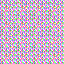

In [29]:
Image('./generated/generated-images-10726.png')
